# Imports

In [216]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_log_error
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from IPython import get_ipython
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Setup plots

In [217]:
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

get_ipython().config.InlineBackend.figure_format = 'retina'

# Some functions to convert values in column between numbers and strings

In [218]:
dictionaries = {}
def convert_to_digits(df, col):
    uniques = df[col].unique()
    #index = df.index
    unique_names = {}
    digits = []
    i = 0
    for uniq in uniques:
        unique_names[uniq] = i
        i = i + 1
    for name in tqdm(df[col]):
        digits = digits + [unique_names[name]]
    dictionaries[col] = unique_names
    return digits

def get_key(d, value):
    return [key for key, val in d.items() if val==value]
    
def convert_back(df, col):
    unique_names = dictionaries[col]
    names = []
    for digit in tqdm(df[col]):
        names = names + get_key(unique_names, digit)
    return names

# Reading needed files with data

In [219]:
holidays_events = pd.read_csv(
    './store-sales-time-series-forecasting/holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

In [220]:
stores = pd.read_csv(
    './store-sales-time-series-forecasting/stores.csv',
    dtype={
        'store_nbr': 'category',
        'city': 'category',
        'state': 'category',
        'type': 'category',
        'cluster': 'category',
    },
    index_col = 'store_nbr',
)

In [221]:
stores['city'] = convert_to_digits(stores, col='city')
stores['state'] = convert_to_digits(stores, col='state')
stores['type'] = convert_to_digits(stores, col='type')

100%|██████████| 54/54 [00:00<00:00, 20936.63it/s]


In [222]:
transactions = pd.read_csv(
    './store-sales-time-series-forecasting/transactions.csv',
    parse_dates=['date'],
    infer_datetime_format=True,
)
transactions = transactions.set_index('date').to_period('D')

In [223]:
oil = pd.read_csv(
    './store-sales-time-series-forecasting/oil.csv',
    parse_dates=['date'],
    infer_datetime_format=True,
)
oil = oil.set_index('date').to_period('D')

In [224]:
store_sales = pd.read_csv(
    './store-sales-time-series-forecasting/train.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales = store_sales.join(oil.fillna(method='bfill'), on='date')
store_sales = store_sales.join(stores, on='store_nbr')
#store_sales = pd.merge(store_sales, transactions, on=['store_nbr', 'date'], how='outer')
store_sales['dcoilwtico'] = store_sales['dcoilwtico'].fillna(method='bfill')

# Useful functions

In [225]:
def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

In [226]:
def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)

# Creating model for Store Sales - Time Series Forecasting competition

### Creating a seasonal model for the full Store Sales dataframe

In [227]:
df_train = store_sales.unstack(['store_nbr', 'family']).loc["2017"]
y = df_train.loc[:, 'sales'].squeeze()

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X_dp = dp.in_sample()
X_dp['NewYear'] = (X_dp.index.dayofyear == 1)

In [228]:
model = LinearRegression(fit_intercept=False)
model.fit(X_dp, y)
y_pred = pd.DataFrame(model.predict(X_dp), index=X_dp.index, columns=y.columns)

In [229]:
y

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2017-01-02        5.0       0.0    0.0    1434.0   0.0   166.819000   
2017-01-03        4.0       0.0    4.0    3081.0   2.0   519.348022   
2017-01-04        1.0       0.0    4.0    3039.0   2.0   543.250977   
2017-01-05        2.0       0.0    3.0    2617.0   0.0   533.479980   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

store_nbr                                            ...         9  \
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-01-01         0.0      0.0     0.0    0.000000  ...       0.0   
2017-01-02         0.0    332.0   376.0   44.980000  ...       5.0   
2017-01-03        15.0    952.0  1045.0  209.300003  ...       2.0   
2017-01-04        17.0   1055.0  1029.0  135.944000  ...       3.0   
2017-01-05        40.0    918.0   853.0  137.005997  ...       2.0   
...                ...      ...     ...         ...  ...       ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...       5.0   
2017-08-12         3.0    351.0   526.0   99.487999  ...       2.0   
2017-08-13         1.0    169.0   266.0   47.770000  ...       3.0   
2017-08-14         4.0    571.0   699.0  154.578003  ...      12.0   
2017-08-15        21.0    703.0   602.0  116.402000  ...      11.0   

store_nbr                                                                  \
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-01-01    0.000000           0.0          0.0                     0.0   
2017-01-02  659.570007        1243.0         11.0                    41.0   
2017-01-03  547.364014         876.0          6.0                    15.0   
2017-01-04  395.287994         677.0          6.0                    13.0   
2017-01-05  470.768005         604.0          7.0                    10.0   
...                ...           ...          ...                     ...   
2017-08-11  309.244995         373.0         11.0                     2.0   
2017-08-12  260.298004         400.0          7.0                    10.0   
2017-08-13  327.205994         510.0          2.0                     9.0   
2017-08-14  330.975006         445.0          2.0                    14.0   
2017-08-15  449.227997         522.0          6.0                     6.0   

store_nbr                                                                      \
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-01-01    0.000000       0.000000     0.000000                        0.0   
2017-01-02  843.596008     115.188995  3136.895996                        1.0   
2017-01-03  714.659973     133.039001  3229.558105                        1.0   
2017-01-04  536.830017      75.201004  1491.416992                        7.0   
2017-01-05  414.100006     113.698997  1566.821045                        1.0   
...                ...            ...          ...                        ...   
2017-08-11  525.223999     112.099998  1453.078003                      140.0   
2017-08-12  383.386993     129.903992  1419.264038                      138.0   
2017-08-13  412.458008     105.168999  1693.607056    

In [230]:
y_pred#.columns.levels

store_nbr              1                                                      \
family        AUTOMOTIVE BABY CARE        BEAUTY     BEVERAGES         BOOKS   
date                                                                           
2017-01-01  2.220446e-14       0.0  2.664535e-14  4.547474e-13  2.775558e-15   
2017-01-02  4.158065e+00       0.0  3.693728e+00  2.438526e+03  6.524888e-01   
2017-01-03  4.019103e+00       0.0  3.790063e+00  2.556636e+03  9.822520e-01   
2017-01-04  4.086815e+00       0.0  3.626226e+00  2.722500e+03  1.070364e+00   
2017-01-05  3.927327e+00       0.0  3.109574e+00  2.342817e+03  7.886527e-01   
...                  ...       ...           ...           ...           ...   
2017-08-11  6.230058e+00       0.0  3.591173e+00  2.269718e+03  4.256072e-01   
2017-08-12  5.340005e+00       0.0  4.242347e+00  2.405677e+03  1.871334e-01   
2017-08-13  2.504829e+00       0.0  2.057165e+00  9.579716e+02  1.501821e-01   
2017-08-14  4.341639e+00       0.0  3.520897e+00  2.143798e+03  1.150321e-01   
2017-08-15  4.103242e+00       0.0  3.616961e+00  2.226185e+03  3.954261e-01   

store_nbr                                                           \
family      BREAD/BAKERY   CELEBRATION      CLEANING         DAIRY   
date                                                                 
2017-01-01  1.705303e-13  6.039613e-14  2.444267e-12  3.296918e-12   
2017-01-02  4.339072e+02  1.278250e+01  7.314578e+02  8.363691e+02   
2017-01-03  4.272647e+02  1.496032e+01  8.624653e+02  8.416939e+02   
2017-01-04  5.002280e+02  1.550328e+01  9.660105e+02  9.806785e+02   
2017-01-05  4.429722e+02  1.901495e+01  7.928288e+02  8.212025e+02   
...                  ...           ...           ...           ...   
2017-08-11  3.488156e+02  2.282886e+01  6.902050e+02  7.470656e+02   
2017-08-12  3.654437e+02  1.544650e+01  5.847289e+02  7.504708e+02   
2017-08-13  1.145495e+02  5.118466e+00  1.798311e+02  2.828302e+02   
2017-08-14  3.328502e+02  1.479510e+01  5.816891e+02  6.666268e+02   
2017-08-15  3.203635e+02  1.671835e+01  7.092581e+02  6.688751e+02   

store_nbr                 ...             9                              \
family              DELI  ...     MAGAZINES         MEATS PERSONAL CARE   
date                      ...                                             
2017-01-01  4.405365e-13  ...  3.019807e-14  6.821210e-13 -3.410605e-13   
2017-01-02  1.590167e+02  ...  3.372874e+00  5.205468e+02  8.060135e+02   
2017-01-03  1.538898e+02  ...  2.618076e+00  4.814580e+02  7.538661e+02   
2017-01-04  1.578011e+02  ...  2.058240e+00  4.258345e+02  6.297048e+02   
2017-01-05  1.313682e+02  ...  1.693960e+00  5.888703e+02  5.486101e+02   
...                  ...  ...           ...           ...           ...   
2017-08-11  1.628032e+02  ...  4.955111e+00  2.546313e+02  2.722978e+02   
2017-08-12  1.355374e+02  ...  5.832216e+00  3.651247e+02  5.354481e+02   
2017-08-13  5.376774e+01  ...  6.674256e+00  3.838337e+02  5.540330e+02   
2017-08-14  1.327222e+02  ...  4.494424e+00  3.158731e+02  3.726632e+02   
2017-08-15  1.313436e+02  ...  3.905065e+00  3.131967e+02  3.593403e+02   

store_nbr                                                                      \
family      PET SUPPLIES PLAYERS AND ELECTRONICS       POULTRY PREPARED FOODS   
date                                                                            
2017-01-01  1.065814e-14            3.552714e-14  7.958079e-13   2.273737e-13   
2017-01-02  9.774855e+00            1.951512e+01  5.960566e+02   1.351610e+02   
2017-01-03  8.359401e+00            1.800615e+01  5.495394e+02   1.304207e+02   
2017-01-04  8.577979e+00            1.546256e+01  4.735746e+02   1.162081e+02   
2017-01-05  5.928875e+00            1.401548e+01  4.097657e+02   1.107939e+02   
...                  ...                     ...           ...            ...   
2017-08-11  6.985302e+00            5.284276e+00  4.328995e+02   9.861047e+01   
2017-08-12  9.981257e+00            1

In [231]:
y_deseason = y - y_pred

In [236]:
y_deseason

store_nbr              1                                                      \
family        AUTOMOTIVE BABY CARE        BEAUTY     BEVERAGES         BOOKS   
date                                                                           
2017-01-01 -2.220446e-14       0.0 -2.664535e-14 -4.547474e-13 -2.775558e-15   
2017-01-02  8.419349e-01       0.0 -3.693728e+00 -1.004526e+03 -6.524888e-01   
2017-01-03 -1.910289e-02       0.0  2.099374e-01  5.243636e+02  1.017748e+00   
2017-01-04 -3.086815e+00       0.0  3.737736e-01  3.165000e+02  9.296362e-01   
2017-01-05 -1.927327e+00       0.0 -1.095736e-01  2.741828e+02 -7.886527e-01   
...                  ...       ...           ...           ...           ...   
2017-08-11 -5.230058e+00       0.0 -2.591173e+00 -1.263718e+03 -4.256072e-01   
2017-08-12  6.599954e-01       0.0 -1.242347e+00 -7.466775e+02 -1.871334e-01   
2017-08-13 -1.504829e+00       0.0 -1.057165e+00 -1.549716e+02 -1.501821e-01   
2017-08-14 -3.341639e+00       0.0  2.479103e+00  5.720162e+01 -1.150321e-01   
2017-08-15 -1.032423e-01       0.0  3.830392e-01 -2.841853e+02 -3.954261e-01   

store_nbr                                                           \
family      BREAD/BAKERY   CELEBRATION      CLEANING         DAIRY   
date                                                                 
2017-01-01 -1.705303e-13 -6.039613e-14 -2.444267e-12 -3.296918e-12   
2017-01-02 -2.670882e+02 -1.278250e+01 -3.994578e+02 -4.603691e+02   
2017-01-03  9.208328e+01  3.967746e-02  8.953468e+01  2.033061e+02   
2017-01-04  4.302301e+01  1.496717e+00  8.898953e+01  4.832154e+01   
2017-01-05  9.050775e+01  2.098505e+01  1.251712e+02  3.179748e+01   
...                  ...           ...           ...           ...   
2017-08-11 -2.032086e+02 -1.882886e+01 -3.492050e+02 -4.040656e+02   
2017-08-12 -1.222237e+02 -1.244650e+01 -2.337289e+02 -2.244708e+02   
2017-08-13  2.212946e+01 -4.118466e+00 -1.083111e+01 -1.683022e+01   
2017-08-14  1.318775e+01 -1.079510e+01 -1.068914e+01  3.237316e+01   
2017-08-15  9.177562e+00  4.281645e+00 -6.258086e+00 -6.687512e+01   

store_nbr                 ...             9                              \
family              DELI  ...     MAGAZINES         MEATS PERSONAL CARE   
date                      ...                                             
2017-01-01 -4.405365e-13  ... -3.019807e-14 -6.821210e-13  3.410605e-13   
2017-01-02 -1.140367e+02  ...  1.627126e+00  1.390232e+02  4.369865e+02   
2017-01-03  5.541024e+01  ... -6.180756e-01  6.590604e+01  1.221339e+02   
2017-01-04 -2.185707e+01  ...  9.417603e-01 -3.054652e+01  4.729516e+01   
2017-01-05  5.637774e+00  ...  3.060396e-01 -1.181023e+02  5.538991e+01   
...                  ...  ...           ...           ...           ...   
2017-08-11 -9.850119e+01  ...  4.488949e-02  5.461374e+01  1.007022e+02   
2017-08-12 -3.604943e+01  ... -3.832216e+00 -1.048267e+02 -1.354481e+02   
2017-08-13 -5.997745e+00  ... -3.674256e+00 -5.662772e+01 -4.403298e+01   
2017-08-14  2.185577e+01  ...  7.505576e+00  1.510190e+01  7.233681e+01   
2017-08-15 -1.494164e+01  ...  7.094935e+00  1.360313e+02  1.626597e+02   

store_nbr                                                                      \
family      PET SUPPLIES PLAYERS AND ELECTRONICS       POULTRY PREPARED FOODS   
date                                                                            
2017-01-01 -1.065814e-14           -3.552714e-14 -7.958079e-13  -2.273737e-13   
2017-01-02  1.225145e+00            2.148488e+01  2.475394e+02  -1.997198e+01   
2017-01-03 -2.359401e+00           -3.006146e+00  1.651206e+02   2.618287e+00   
2017-01-04 -2.577979e+00           -2.462563e+00  6.325539e+01  -4.100709e+01   
2017-01-05  1.071125e+00           -4.015484e+00  4.334323e+00   2.905121e+00   
...                  ...                     ...           ...            ...   
2017-08-11  4.014698e+00           -3.284276e+00  9.232449e+01   1.348953e+01   
2017-08-12 -2.981257e+00           -1

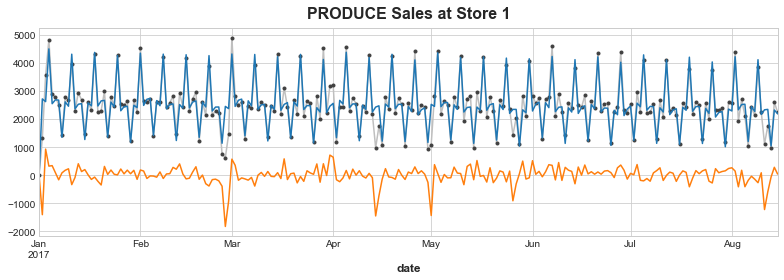

In [237]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
# display(store_sales.index.get_level_values('family').unique())

ax = df_train.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)[STORE_NBR, FAMILY].plot(ax=ax)
ax = y_deseason.loc(axis=1)[STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [238]:
df_train_deseason = df_train.copy()
df_train_deseason.loc[:, 'sales'] = y_deseason

In [239]:
df_train_deseason

id                                                     \
store_nbr           1                                                      
family     AUTOMOTIVE BABY CARE   BEAUTY BEVERAGES    BOOKS BREAD/BAKERY   
date                                                                       
2017-01-01    2596374   2596375  2596376   2596377  2596378      2596379   
2017-01-02    2598156   2598157  2598158   2598159  2598160      2598161   
2017-01-03    2599938   2599939  2599940   2599941  2599942      2599943   
2017-01-04    2601720   2601721  2601722   2601723  2601724      2601725   
2017-01-05    2603502   2603503  2603504   2603505  2603506      2603507   
...               ...       ...      ...       ...      ...          ...   
2017-08-11    2991978   2991979  2991980   2991981  2991982      2991983   
2017-08-12    2993760   2993761  2993762   2993763  2993764      2993765   
2017-08-13    2995542   2995543  2995544   2995545  2995546      2995547   
2017-08-14    2997324   2997325  2997326   2997327  2997328      2997329   
2017-08-15    2999106   2999107  2999108   2999109  2999110      2999111   

                                                   ...   cluster        \
store_nbr                                          ...         9         
family     CELEBRATION CLEANING    DAIRY     DELI  ... MAGAZINES MEATS   
date                                               ...                   
2017-01-01     2596380  2596381  2596382  2596383  ...         6     6   
2017-01-02     2598162  2598163  2598164  2598165  ...         6     6   
2017-01-03     2599944  2599945  2599946  2599947  ...         6     6   
2017-01-04     2601726  2601727  2601728  2601729  ...         6     6   
2017-01-05     2603508  2603509  2603510  2603511  ...         6     6   
...                ...      ...      ...      ...  ...       ...   ...   
2017-08-11     2991984  2991985  2991986  2991987  ...         6     6   
2017-08-12     2993766  2993767  2993768  2993769  ...         6     6   
2017-08-13     2995548  2995549  2995550  2995551  ...         6     6   
2017-08-14     2997330  2997331  2997332  2997333  ...         6     6   
2017-08-15     2999112  2999113  2999114  2999115  ...         6     6   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2017-01-01             6            6                       6       6   
2017-01-02             6            6                       6       6   
2017-01-03             6            6                       6       6   
2017-01-04             6            6                       6       6   
2017-01-05             6            6                       6       6   
...                  ...          ...                     ...     ...   
2017-08-11             6            6                       6       6   
2017-08-12             6            6                       6       6   
2017-08-13             6            6                       6       6   
2017-08-14             6            6                       6       6   
2017-08-15             6            6                       6       6   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2017-01-01              6       6                          6       6  
2017-01-02              6       6                          6       6  
2017-01-03              6       6                          6       6  
2017-01-04              6       6                          6       6  
2017-01-05              6       6                          6       6  
...                   ...     ..

In [240]:
df_train_deseason = df_train.copy()
for col in tqdm(df_train.columns):
    if col[0] == 'sales':
        df_train_deseason[col] = y_deseason[(col[1], col[2])]

100%|██████████| 14256/14256 [00:04<00:00, 3079.92it/s]


### Adding lags

In [241]:
df_train_lags = y_deseason.copy()
for col in tqdm(y_deseason.columns):
    if col[0] == 'sales':
        name_lags = (col[0], col[1], f'{col[2]}_lags_1')
        name_mean = (col[0], col[1], f'{col[2]}_lags_mean_7')
        name_std = (col[0], col[1], f'{col[2]}_lags_std_7')
        new_cols = pd.MultiIndex.from_tuples([name_lags, name_mean, name_std])
        df_train_lags = df_train_lags.reindex(columns=df_train_lags.columns.union(new_cols))
        df_train_lags[name_lags] = make_lags(df_train_lags[col], lags=1)
        df_train_lags[name_mean] = df_train_lags[name_lags].ewm(alpha=0.13).mean()
        df_train_lags[name_std] = df_train_lags[name_lags].ewm(alpha=0.13).std()
#X_lags

100%|██████████| 1782/1782 [00:00<00:00, 281431.20it/s]


In [242]:
df_train_promo = df_train_lags.copy()
for col in tqdm(df_train_lags.columns):
    if col[0] == 'onpromotion':
        onpromotion = df_train_lags[col].squeeze().rename('onpromotion')
        name_lags = (col[0], col[1], f'{col[2]}_promo_lags_1')
        name_leads = (col[0], col[1], f'{col[2]}_promo_lead_0')
        name_mean = (col[0], cl[1], f'{col[2]}_promo_mean_7')
        new_cols = pd.MultiIndex.from_tuples([name_lags, name_leads, name_mean])
        df_train_promo = df_train_promo.reindex(columns=df_train_promo.columns.union(new_cols))
        df_train_promo[name_lags] = make_lags(onpromotion, lags=1, name='y_promo')
        df_train_promo[name_leads] = make_leads(onpromotion, leads=1)
        df_train_promo[name_mean] = onpromotion.ewm(alpha=0.13).mean()

100%|██████████| 1782/1782 [00:00<00:00, 300267.14it/s]


In [243]:
df_train_final = df_train_promo.copy()

### Loading test data and check the efficincy of our model on it

In [244]:
df_test = pd.read_csv(
    './store-sales-time-series-forecasting/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)

y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])

In [245]:
#y_submit = y_submit.drop(columns=['city','cluster','dcoilwtico','onpromotion','state','type'])
#y_submit.to_csv('submission.csv', index=False)